In [1]:
import tensorflow as tf
import os
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Dense
from keras.models import Sequential, load_model
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
#pathlib would make errors on the image extension when iterating 
# through the data, so imghdr would be a better alternative
import imghdr
import cv2
import numpy as np

C:\Users\nishi\AppData\Local\Temp\ipykernel_12572\1299890961.py:10: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
data_dir = 'data'
log_dir = 'logs'
image_ext = ['jpeg', 'jpg', 'png', 'bmp']

In [3]:
cat_images = os.listdir(os.path.join(data_dir, 'cat'))
dog_images = os.listdir(os.path.join(data_dir, 'dog'))
print(cat_images[0])
print(dog_images[0])

07CAT-STRIPES-mediumSquareAt3X-v2.jpg
-puppy-dog-sitting-frontal-looking-camera-isolated-white-background-46868560.jpg


In [4]:
image = cv2.imread(os.path.join(data_dir, 'cat', '07CAT-STRIPES-mediumSquareAt3X-v2.jpg'))
image.shape

(1800, 1800, 3)

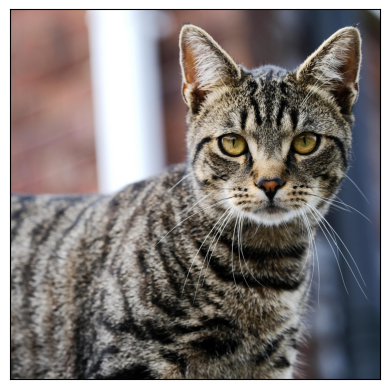

In [5]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
for imageClass in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, imageClass)):
    image_path = os.path.join(data_dir, imageClass, image)
    try:
      extension = imghdr.what(image_path)
      if extension not in image_ext:
        print(f"Unsupported Image Extension: {image_path}")
        os.remove(image_path)
    except Exception as e:
      print(f"Issue with Image path: {image_path}")
      os.remove(image_path)
  

In [7]:
image_height = 224
image_width = 224

In [8]:
data = image_dataset_from_directory(data_dir,
                                    image_size=(image_height, image_width))

Found 420 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
batch[0].shape

(32, 224, 224, 3)

In [12]:
batch[1]

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0])

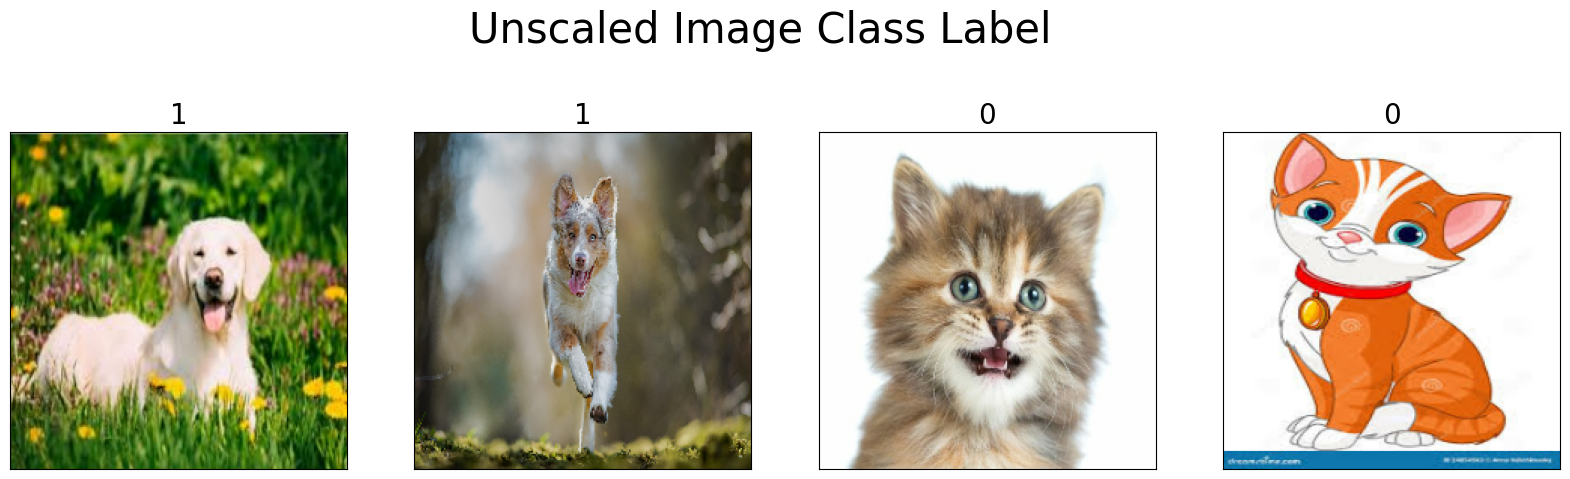

In [13]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 6))
fig.suptitle("Unscaled Image Class Label", fontsize=30)
for i, img in enumerate(batch[0][:4]):
  ax[i].imshow(img.astype(int))
  ax[i].set_title(batch[1][i], fontsize=20)
  ax[i].set_xticks([])
  ax[i].set_yticks([])
#Cat is 0
#Dog is 1

In [14]:
#Be sure to run this code once as it may turn all pixel values into small values
data = data.map(lambda x, y: (x/255, y))

In [15]:
scaled_iterator = data.as_numpy_iterator()

In [16]:
batch = scaled_iterator.next()

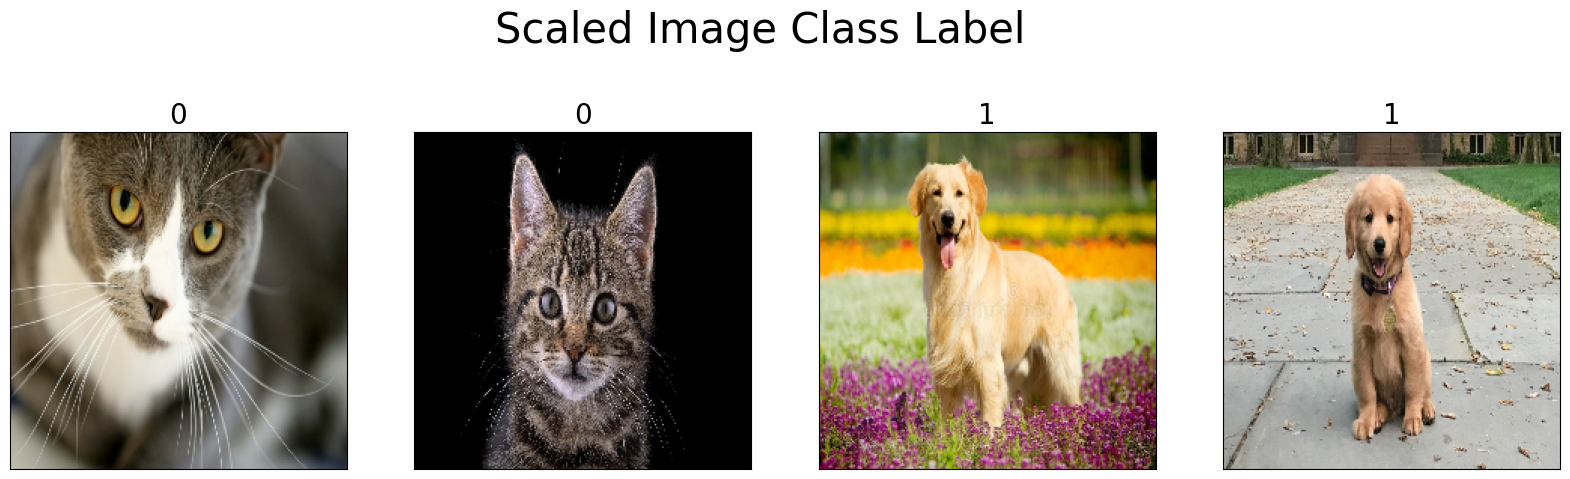

In [17]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 6))
fig.suptitle("Scaled Image Class Label", fontsize=30)
for i, img in enumerate(batch[0][:4]):
  ax[i].imshow(img) #Dont use astype(int) as it would round to 0, 1
  ax[i].set_title(batch[1][i], fontsize=20)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

In [18]:
len(data)

14

In [19]:
train_size = int(len(data) * 0.7)
valid_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [20]:
print(f"Train Size: {train_size}")
print(f"Valid Size: {valid_size}")
print(f"Test Size: {test_size}")
#If any of the size is 0, either get more data or lower the batch size
# A size of 0 would make errors, which you would not be able to compute
# the test accuracy, recall, and precision

Train Size: 9
Valid Size: 2
Test Size: 1


In [21]:
train = data.take(train_size)
valid = data.skip(train_size).take(valid_size)
test = data.skip(train_size + valid_size).take(test_size)

In [22]:
# def VGG16():  
#   model = Sequential([
#     Conv2D(64, (3,3), 1, 'Same', activation='relu', input_shape=(image_height, image_width, 3)),
#     Conv2D(64, (3,3), 1, 'Same', activation='relu'),
#     MaxPool2D((2,2), (2,2)),
#     Conv2D(128, (3,3), 1, 'Same', activation='relu'),
#     Conv2D(128, (3,3), 1, 'Same', activation='relu'),
#     MaxPool2D((2,2), (2,2)),
#     Conv2D(256, (3,3), 1, 'Same', activation='relu'),
#     Conv2D(256, (3,3), 1, 'Same', activation='relu'),
#     Conv2D(256, (3,3), 1, 'Same', activation='relu'),
#     MaxPool2D((2,2), (2,2)),
#     Conv2D(512, (3,3), 1, 'Same', activation='relu'),
#     Conv2D(512, (3,3), 1, 'Same', activation='relu'),
#     Conv2D(512, (3,3), 1, 'Same', activation='relu'),
#     MaxPool2D((2,2), (2,2)),
#     Conv2D(512, (3,3), 1, 'Same', activation='relu'),
#     Conv2D(512, (3,3), 1, 'Same', activation='relu'),
#     Conv2D(512, (3,3), 1, 'Same', activation='relu'),
#     MaxPool2D((2,2), (2,2)),
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(1, activation='linear')
#   ])

#   return model

In [23]:
model = Sequential([
  Conv2D(16, (3,3), 1, padding='Same', activation='relu', input_shape=(image_height, image_width, 3)), 
  MaxPool2D(),
  Conv2D(32, (3,3), 1, padding='Same', activation='relu'),
  MaxPool2D(),
  Conv2D(16, (3,3), 1, padding='Same', activation='relu'),
  MaxPool2D(),
  Dropout(0.2), 
  Flatten(),
  Dense(256, activation='relu'),
  Dense(1), #Linear activation (default) to apply from_logits=True
  ])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 16)        0

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [27]:
batch_size = 32
epochs = 20

In [28]:
history = model.fit(train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=valid,
                    callbacks=[tensorboard_callback]) 

Epoch 1/20
9/9 [==============================] - 19s 2s/step - loss: 0.8896 - accuracy: 0.5729 - val_loss: 0.7008 - val_accuracy: 0.5781
Epoch 2/20
9/9 [==============================] - 23s 2s/step - loss: 0.6822 - accuracy: 0.5278 - val_loss: 0.7137 - val_accuracy: 0.7031
Epoch 3/20
9/9 [==============================] - 21s 2s/step - loss: 0.6307 - accuracy: 0.6458 - val_loss: 0.6868 - val_accuracy: 0.7031
Epoch 4/20
9/9 [==============================] - 17s 2s/step - loss: 0.5681 - accuracy: 0.7569 - val_loss: 0.4793 - val_accuracy: 0.7812
Epoch 5/20
9/9 [==============================] - 17s 2s/step - loss: 0.4685 - accuracy: 0.7604 - val_loss: 0.4312 - val_accuracy: 0.9062
Epoch 6/20
9/9 [==============================] - 18s 2s/step - loss: 0.3346 - accuracy: 0.8472 - val_loss: 0.3317 - val_accuracy: 0.8750
Epoch 7/20
9/9 [==============================] - 18s 2s/step - loss: 0.2662 - accuracy: 0.8924 - val_loss: 0.1989 - val_accuracy: 0.9219
Epoch 8/20
9/9 [==================

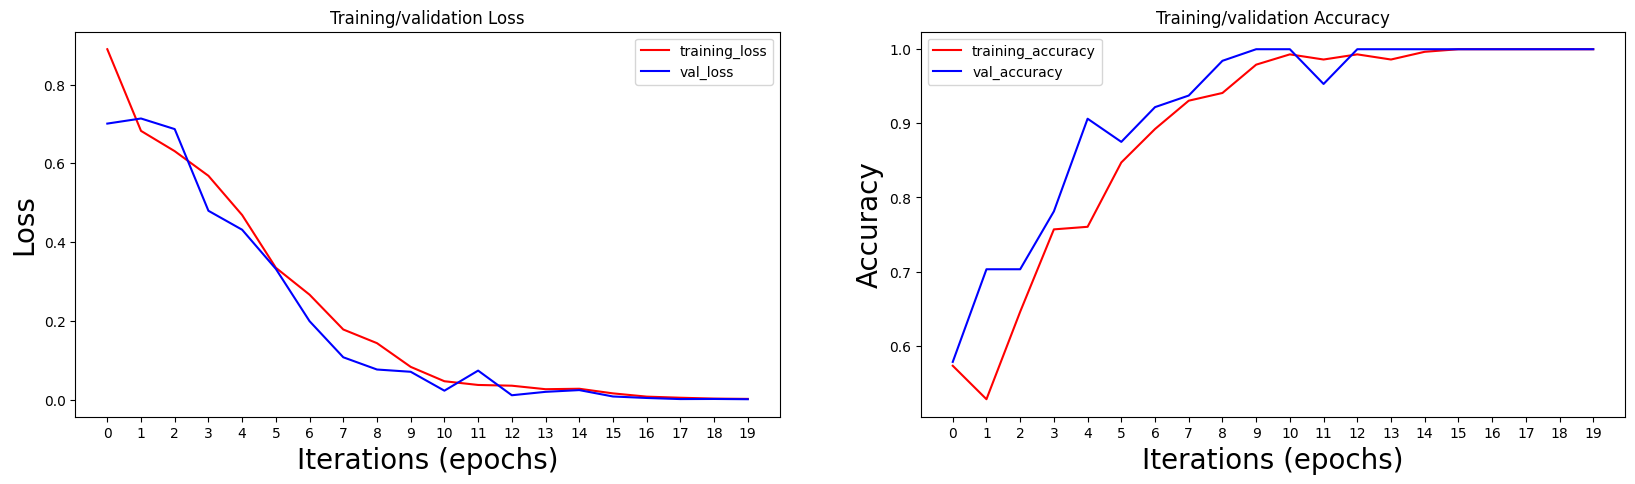

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("Training/validation Loss")
ax[0].plot(history.history['loss'], label='training_loss', color='red')
ax[0].plot(history.history['val_loss'], label='val_loss', color='blue')
ax[0].set_xlabel("Iterations (epochs)", fontsize=20)
ax[0].set_ylabel("Loss", fontsize=20)
ax[0].set_xticks(range(0, 20))
ax[0].legend()

ax[1].set_title("Training/validation Accuracy")
ax[1].plot(history.history['accuracy'], label='training_accuracy', color='red')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax[1].set_xlabel("Iterations (epochs)", fontsize=20)
ax[1].set_ylabel("Accuracy", fontsize=20)
ax[1].set_xticks(range(0, 20))
ax[1].legend()
plt.show()

In [30]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = tf.nn.sigmoid(model.predict(X))
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

1/1 [==============================] - 1s 524ms/step


In [32]:
print(f"Accuracy\n\t{accuracy.result().numpy()}\nPrecision\n\t{precision.result().numpy()}\nRecall\n\t{recall.result().numpy()}")

Accuracy
	1.0
Precision
	1.0
Recall
	1.0


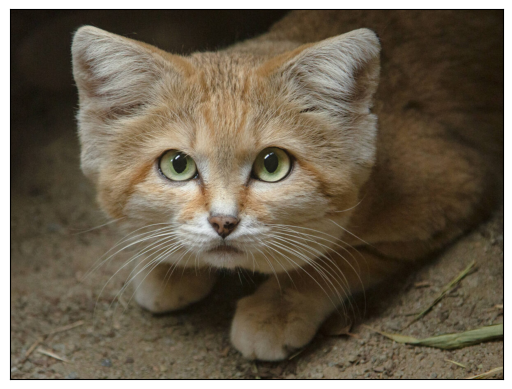

In [33]:
image = cv2.imread('cattest.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

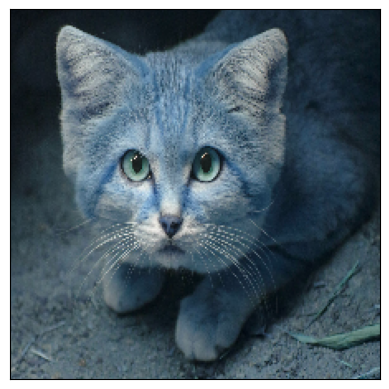

In [34]:
resized_image = tf.image.resize(image, (224, 224))
plt.imshow(resized_image.numpy().astype(int))
plt.xticks([])
plt.yticks([])
plt.show()

In [35]:
resized_image = resized_image / 255

In [36]:
image = np.expand_dims(resized_image, axis=0)

In [37]:
yhat = tf.nn.sigmoid(model.predict(image))

1/1 [==============================] - 0s 134ms/step


In [38]:
yhat.numpy()

array([[0.00046278]], dtype=float32)

In [39]:
if yhat > 0.5:
  print("Woof")
else: 
  print("Meow")

Meow


In [41]:
model.save(os.path.join('models', 'classifier.keras'))

In [42]:
new_model = load_model(os.path.join('models', 'classifier.keras'))

In [43]:
yhat = tf.nn.sigmoid(model.predict(image))

1/1 [==============================] - 0s 49ms/step


In [44]:
if yhat > 0.5:
  print("woof")
else:
  print("meow")

meow
